## Finding Hidden Patterns Using Unsupervised Learning Techniques (PCA) and Clustering Algorithm

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams['figure.figsize'] = [10, 7]
pd.options.display.max_rows=1000
pd.options.display.max_columns=100

### Sample data can be downloaded from [here](https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k)

### Access data that was downloaded beforehand:

In [2]:
%%time
data = pd.read_csv('data/bike_data.csv', index_col='Date', parse_dates=True)

CPU times: user 10.9 s, sys: 25.8 ms, total: 10.9 s
Wall time: 10.9 s


In [3]:
data.head()

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2019-03-31 23:00:00,6.0,10.0
2019-03-31 22:00:00,7.0,14.0
2019-03-31 21:00:00,18.0,15.0
2019-03-31 20:00:00,26.0,31.0
2019-03-31 19:00:00,30.0,58.0


### But let me first introduce you to parquet file format.  It is so much faster to read to and read in a parquet file:

In [4]:
%%time
data.to_parquet('data/bike_data.parquet')

CPU times: user 63.1 ms, sys: 13 ms, total: 76.1 ms
Wall time: 74.5 ms


In [5]:
%%time
data = pd.read_parquet('data/bike_data.parquet')

CPU times: user 9.74 ms, sys: 2.02 ms, total: 11.8 ms
Wall time: 10.2 ms


In [6]:
data.head()

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2019-03-31 23:00:00,6.0,10.0
2019-03-31 22:00:00,7.0,14.0
2019-03-31 21:00:00,18.0,15.0
2019-03-31 20:00:00,26.0,31.0
2019-03-31 19:00:00,30.0,58.0


### Let's rename columns and create a ```Total``` column:

In [7]:
data.columns = ['West', 'East']
data.fillna(0, inplace=True)
data['Total'] = data.eval('East + West')
data.head()

,West,East,Total
Date,,,
2019-03-31 23:00:00,6.0,10.0,16.0
2019-03-31 22:00:00,7.0,14.0,21.0
2019-03-31 21:00:00,18.0,15.0,33.0
2019-03-31 20:00:00,26.0,31.0,57.0
2019-03-31 19:00:00,30.0,58.0,88.0


### Let's plot this data on a weekly-basis and sum the bike trips:

#### BEFORE resampling:

In [8]:
data.head(10)

,West,East,Total
Date,,,
2019-03-31 23:00:00,6.0,10.0,16.0
2019-03-31 22:00:00,7.0,14.0,21.0
2019-03-31 21:00:00,18.0,15.0,33.0
2019-03-31 20:00:00,26.0,31.0,57.0
2019-03-31 19:00:00,30.0,58.0,88.0
2019-03-31 18:00:00,73.0,89.0,162.0
2019-03-31 17:00:00,99.0,106.0,205.0
2019-03-31 16:00:00,106.0,105.0,211.0
2019-03-31 15:00:00,130.0,121.0,251.0


#### AFTER resampling:

In [9]:
data.resample('W').sum()[:10]

,West,East,Total
Date,,,
2012-10-07,7297.0,6995.0,14292.0
2012-10-14,8679.0,8116.0,16795.0
2012-10-21,7946.0,7563.0,15509.0
2012-10-28,6901.0,6536.0,13437.0
2012-11-04,6408.0,5786.0,12194.0
2012-11-11,7741.0,7275.0,15016.0
2012-11-18,6077.0,5799.0,11876.0
2012-11-25,3534.0,3316.0,6850.0
2012-12-02,5875.0,5659.0,11534.0


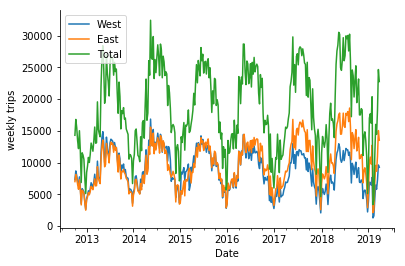

In [10]:
data.resample('W').sum().plot()
plt.ylabel('weekly trips')
sns.despine();

From above, we see a seasonal trend with most bike trips occuring in the middle of the year.

We will consider each day in the dataset as its own separate entity or observation. For each day, we have 48 observations: two observations (east and west sidewalk sensors) for each of the 24 hour-long periods. By examining the days in light of these observations and doing some careful analysis, we should be able to extract meaningful quantitative statements from the data themselves, without the need to lean on any other assumptions.

### Number of trips in each hour:

In [11]:
pivoted = data.pivot_table(['East', 'West'],
                           index=data.index.date,
                           columns=data.index.hour,
                           fill_value=0)
pivoted.head()

East                                                               \
Date         0  1  2  3  4   5   6    7    8    9   10  11  12  13   14   15   
2012-10-03    9  6  1  3  1  10  50   95  146  104  46  32  41  48   51   92   
2012-10-04   11  0  6  3  1  11  51   89  134   94  53  55  50  71   56   74   
2012-10-05    7  4  3  2  2   7  37  101  119   81  48  61  46  50   62   84   
2012-10-06    7  5  2  2  1   2  15   16   47   55  47  48  73  82  114   96   
2012-10-07    5  5  1  2  2   3   8   12   26   36  41  71  91  99  115  109   

                                               West                        \
Date         16   17   18   19  20  21  22  23   0   1  2  3  4   5    6    
2012-10-03  182  391  258   69  51  38  25  12    4   4  1  2  6  21  105   
2012-10-04  161  353  241  107  56  39  21  30    7   3  3  0  7  15   91   
2012-10-05  190  290  209   73  41  31  26  16    4   4  4  2  7  18   68   
2012-10-06   76   73   55   38  18  15  20  19    8  10  7  1  4   3   12   
2012-10-07   93   73   45   23  36  35   9  11    6  12  2  4  1   6    9   

                                                                              \
Date         7    8    9   10  11   12   13   14   15   16   17   18  19  20   
2012-10-03  257  291  172  72  10   35   42   77   72  133  192  122  59  29   
2012-10-04  230  284  147  67  53   54   55   63   73  114  154  137  57  27   
2012-10-05  218  251  131  71  43   55   62   63   80  120  144  107  42  27   
2012-10-06   17   58   59  68  76   91   95   89  115  107  107   41  40  25   
2012-10-07   14   43   67  67  94  100  129  126  122  132  118   68  26  19   

                        
Date        21  22  23  
2012-10-03  25  24   5  
2012-10-04  31  25  11  
2012-10-05  11  10  16  
2012-10-06  18  14  15  
2012-10-07  12   9   5

In [12]:
X = pivoted.values
X.shape

(2371, 48)

We can think of this data now as representing 2,371 distinct objects which live in a *48-dimensional* space: the value of each dimension is the number of bicycle trips measured on a particular side of the bridge at a particular hour. Visualizing 48-dimensional data is quite difficult, so instead we will use a standard dimensionality reduction technique to project this to a more manageable size: 2 dimensions

### Reduce our matrix from 48-dimensional space to 2-dimensional space:

In [13]:
from sklearn.decomposition import PCA
Xpca = PCA(n_components=2).fit_transform(X)
Xpca.shape

(2371, 2)

Here is a sample of what our newly reduced data looks like:

In [26]:
Xpca[:20]

array([[ 236.73244416,   -3.79739832],
       [ 181.64359285,   23.42437395],
       [ 102.2040515 ,   29.74514982],
       [-319.23442911,  147.76942058],
       [-326.91350939,  207.28325032],
       [ 220.816495  ,   15.47623312],
       [ 247.39442746,  -27.39225669],
       [ 186.3774968 ,  -39.03338873],
       [ 129.38592126,  -10.73974957],
       [-111.32481191,  -56.39748869],
       [-440.05970699,  -62.980303  ],
       [-466.58408145,  -52.99423057],
       [ -42.20201738,  -66.63862194],
       [ 111.0866629 ,   -2.14010914],
       [ 151.72408732,   -2.71507059],
       [  91.28586844,   -8.90113339],
       [-113.16554337,  -55.90774452],
       [-420.4619429 ,   -1.17365666],
       [-427.45535821,   -5.31328229],
       [ -12.98048485, -125.56981786]])

In [14]:
total_trips = X.sum(1)

In [15]:
total_trips[:5]

array([3521, 3475, 3148, 2006, 2142])

In [16]:
pivoted.sum(axis='columns')[:5]

2012-10-03    3521
2012-10-04    3475
2012-10-05    3148
2012-10-06    2006
2012-10-07    2142
dtype: int64

### Now that we have 2-D data, let's make a scatter plot:

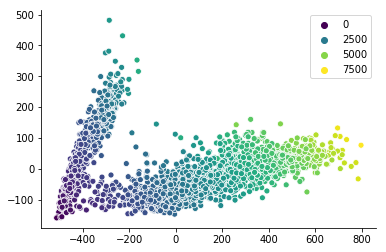

In [17]:
sns.scatterplot(x=Xpca[:, 0], y=Xpca[:, 1], hue=total_trips, palette='viridis')
sns.despine();

So it appears we have 2 distinct groups in our data.  So how do we label or categorize them?

### Use a clustering algorithm to add cluster label.  We'll use Gaussian Mixture Model:

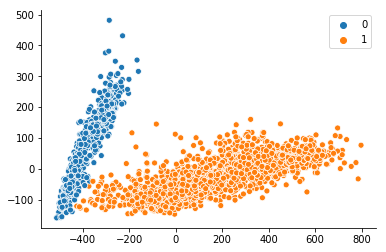

In [18]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
gmm.fit(Xpca)
cluster_label = gmm.predict(Xpca)
sns.scatterplot(x=Xpca[:, 0], y=Xpca[:, 1], hue=cluster_label)
sns.despine()

We now have our cluster label data, but we need to somehow combine it with our data using pandas ```join()``` or ```merge()``` functions.

### Now join our cluster label data with our original bike data so that we end up with a ```Cluster``` column:

In [19]:
pivoted['Cluster'] = cluster_label
data = data.join(pivoted['Cluster'], on=data.index.date)
data.head()

,West,East,Total,Cluster
Date,,,,
2019-03-31 23:00:00,6.0,10.0,16.0,0
2019-03-31 22:00:00,7.0,14.0,21.0,0
2019-03-31 21:00:00,18.0,15.0,33.0,0
2019-03-31 20:00:00,26.0,31.0,57.0,0
2019-03-31 19:00:00,30.0,58.0,88.0,0


### But let's summarize or resample our data to hourly intervals and calculate the mean trips:

In [20]:
# or by_hour = data.pivot_table(index=['Cluster', data.index.time], aggfunc='mean')
by_hour = data.groupby(['Cluster', data.index.time]).mean()
by_hour

West        East       Total
Cluster                                             
0       00:00:00    6.541384    9.105834   15.647218
        01:00:00    4.075984    5.081411    9.157395
        02:00:00    2.858887    3.123474    5.982361
        03:00:00    1.761194    1.698779    3.459973
        04:00:00    1.687924    2.245590    3.933514
        05:00:00    4.123474    3.242877    7.366350
        06:00:00    8.221167    8.599729   16.820896
        07:00:00   16.548168   14.522388   31.070556
        08:00:00   30.605156   26.626866   57.232022
        09:00:00   41.622795   36.282225   77.905020
        10:00:00   51.242877   42.101764   93.344640
        11:00:00   59.903664   51.534600  111.438263
        12:00:00   65.435550   58.077341  123.512890
        13:00:00   68.386703   62.538670  130.925373
        14:00:00   69.169607   63.335142  132.504749
        15:00:00   67.446404   62.710991  130.157395
        16:00:00   61.484396   58.251018  119.735414
        17:00:00   50.986431   49.420624  100.407056
        18:00:00   39.785617   37.808684   77.594301
        19:00:00   26.426052   26.511533   52.937585
        20:00:00   18.654003   20.450475   39.104478
        21:00:00   13.313433   15.164179   28.477612
        22:00:00    9.778833   11.917232   21.696065
        23:00:00    7.546811   10.843962   18.390773
1       00:00:00    4.296818    5.525092    9.821909
        01:00:00    2.197062    2.544064    4.741126
        02:00:00    1.604039    1.606487    3.210526
        03:00:00    1.473684    1.294982    2.768666
        04:00:00    4.339045    3.401469    7.740514
        05:00:00   21.744798   12.368421   34.113219
        06:00:00   77.747858   45.321909  123.069767
        07:00:00  205.292534  107.957160  313.249694
        08:00:00  272.419829  163.059364  435.479192
        09:00:00  134.983476   99.572827  234.556304
        10:00:00   53.539168   45.291922   98.831089
        11:00:00   38.761934   34.231946   72.993880
        12:00:00   38.569155   35.969400   74.538556
        13:00:00   40.551408   39.732558   80.283966
        14:00:00   42.962668   48.541004   91.503672
        15:00:00   56.864749   76.802938  133.667687
        16:00:00   89.917993  175.586903  265.504896
        17:00:00  138.891065  366.384945  505.276010
        18:00:00  112.130355  231.964504  344.094859
        19:00:00   59.181763  102.192778  161.374541
        20:00:00   35.394737   53.682987   89.077723
        21:00:00   24.038556   31.548348   55.586903
        22:00:00   15.425949   20.318237   35.744186
        23:00:00    9.140759   12.760710   21.901469

### Now, let's chart our data with hour as the x-axis and mean trips as y-axis:

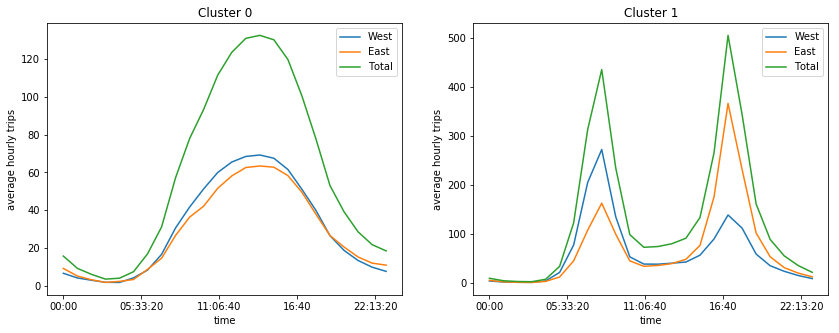

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

for i in range(2):
    by_hour.loc[i].plot(ax=ax[i])
    ax[i].set_title('Cluster {0}'.format(i))
    ax[i].set_ylabel('average hourly trips')

#### From above, we see that our x-axis labels are not in hourly format.  Below is how we can fix that by specifying ```xticks``` parameter and rotating the labels 90 degrees:

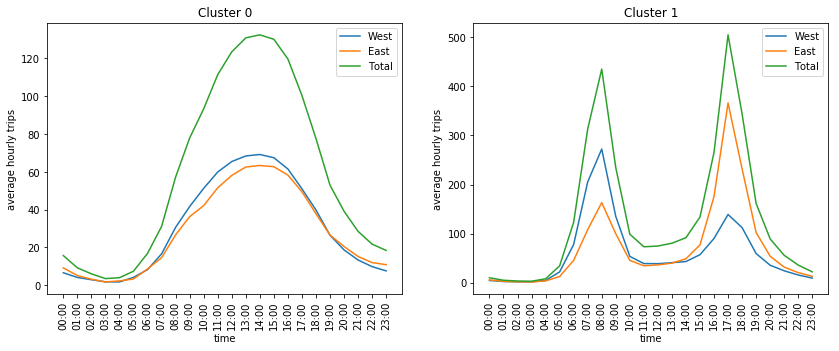

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

for i in range(2):
    by_hour.loc[i].plot(ax=ax[i], xticks=by_hour.loc[i].index)
    plt.setp(ax[i].xaxis.get_majorticklabels(),rotation=90)
    ax[i].set_title('Cluster {0}'.format(i))
    ax[i].set_ylabel('average hourly trips')

#### What's cool about the charts above, they show that for one clustering (0), we have a Normal/Gaussian-like distribution of bike trips, but for the other cluster group (1), we have a peak at the beginning of the day and also a peak at the end of the day. So why are we seeing these 2 behaviors?  We can deduce or suspect that the bikers in cluster group 0 are perhaps weekend bikers and the bikers in cluster group 1 are weekend bikers.  So let's plot our data to confirm.

### Plot our clustering using an additional visual aide by mapping day of the week to a color scale:

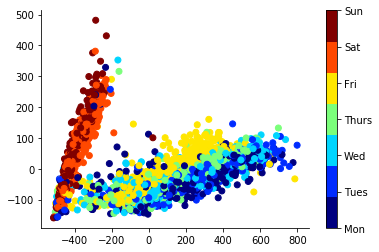

In [23]:
dayofweek = pd.to_datetime(pivoted.index).dayofweek
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=dayofweek,
            cmap=plt.cm.get_cmap('jet', 7))
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
sns.despine();

The chart above confirms our suspicion that the bikers in Cluster 0 are indeed weekend bikers!

#### As a reminder, below was our 2 clusters from using the Gaussian Mixture model:

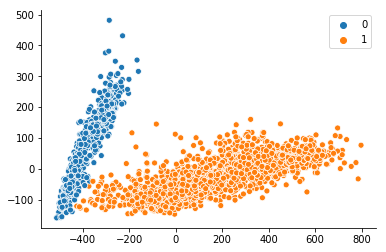

In [24]:
sns.scatterplot(x=Xpca[:, 0], y=Xpca[:, 1], hue=cluster_label)
sns.despine()

# Recap

We used principal component analysis (PCA) to reduce our dimension space to a more "human-friendly" 2D space and then with clustering algorithm to do the labeling, we were able to identify from the data itself that there are 2 distinct types or groups of bikers: weekend bikers and weekday bikers